## Old

In [ ]:
# Read Files
folder_name = "results"
#   Find files in folder
import os

files = os.listdir(folder_name)
#   Read files
file_texts = {}
for file in files:
    # If file is not a text file, skip it
    if not file.endswith(".txt"):
        continue
    with open(folder_name + "/" + file, "r") as f:
        file_texts[file] = f.read()

In [12]:
[file_name.split("_") for file_name in files]

[['resnet152', '16.txt'],
 ['resnet152', '64.txt'],
 ['resnet50', '1.txt'],
 ['bert', '2.txt'],
 ['resnet50', '2.txt'],
 ['resnet152', '2.txt'],
 ['bert', '128.txt'],
 ['resnet152.png'],
 ['bert.txt'],
 ['bert', '16.txt'],
 ['bert', '1.txt'],
 ['resnet50', '4.txt'],
 ['bert', '64.txt'],
 ['resnet152.txt'],
 ['bert', '4.txt'],
 ['resnet152', '256.txt'],
 ['resnet152', '128.txt'],
 ['resnet50', '256.txt'],
 ['bert', '256.txt'],
 ['resnet50.png'],
 ['resnet152', '512.txt'],
 ['resnet152', '4.txt'],
 ['resnet50', '64.txt'],
 ['resnet50.txt'],
 ['resnet50', '8.txt'],
 ['bert', '32.txt'],
 ['resnet152', '8.txt'],
 ['bert', '8.txt'],
 ['resnet50', '32.txt'],
 ['resnet50', '128.txt'],
 ['resnet152', '1.txt'],
 ['resnet50', '16.txt'],
 ['bert.png'],
 ['resnet152', '32.txt']]

In [7]:
# Parse Texts
import pandas as pd
import re

df = pd.DataFrame(
    columns=[
        "model",
        "batch_size",
        "op_id",
        "reserved_mem",
        "allocated_mem",
        "free_mem",
    ]
)
for file, file_text in file_texts.items():
    if len(file_text.split("_")) < 2:
        continue
    model = file.split("_")[0]
    batch_size = file.split("_")[1].split(".")[0]
    lines = file_text.split("\n")
    pattern = re.compile(r"\((\d+)\) reserved: (\d+), allocated: (\d+), free: (\d+)")
    for line in lines:
        mem_line = re.findall(pattern, line.strip())
        if mem_line:
            op_id, reserved_mem, allocated_mem, free_mem = re.findall(
                pattern, line.strip()
            )[0]
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        [
                            [
                                model,
                                batch_size,
                                op_id,
                                reserved_mem,
                                allocated_mem,
                                free_mem,
                            ]
                        ],
                        columns=df.columns,
                    ),
                ],
                ignore_index=True,
            )
        else:
            print("Error: ", line)
df

Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  
Error:  Running model: torchbenchmark.models.hf_Bert.Model
Error:  


,model,batch_size,op_id,reserved_mem,allocated_mem,free_mem
0,bert,2,1,494927872,439214592,55713280
1,bert,2,2,494927872,439214592,55713280
2,bert,2,3,494927872,439214592,55713280
3,bert,2,4,494927872,439214592,55713280
4,bert,2,5,494927872,439214592,55713280
...,...,...,...,...,...,...
40577,bert,8,6386,7298088960,448028160,6850060800
40578,bert,8,6387,7298088960,448028160,6850060800
40579,bert,8,6388,7298088960,448028160,6850060800
40580,bert,8,6389,7298088960,448028160,6850060800


In [14]:
df.groupby(["model", "batch_size"]).count()

op_id  reserved_mem  allocated_mem  free_mem
model batch_size                                              
bert  1            6329          6329           6329      6329
      128           702           702            702       702
      16           6390          6390           6390      6390
      2            6390          6390           6390      6390
      256           477           477            477       477
      32           6390          6390           6390      6390
      4            6390          6390           6390      6390
      64           1124          1124           1124      1124
      8            6390          6390           6390      6390

In [15]:
# Remove (model, batch_size) pairs with less than the maximum number of operations
df_complete = df.groupby(["model", "batch_size"]).filter(
    lambda x: len(x) == df.groupby(["model", "batch_size"]).size().max()
)
# Get peak memory usage for every model and batch size
df_peak = (
    df_complete.groupby(["model", "batch_size"])["allocated_mem"].max().reset_index()
)
df_peak

,model,batch_size,allocated_mem
0,bert,16,9999753728
1,bert,2,999750656
2,bert,32,997308416
3,bert,4,998787072
4,bert,8,998657024


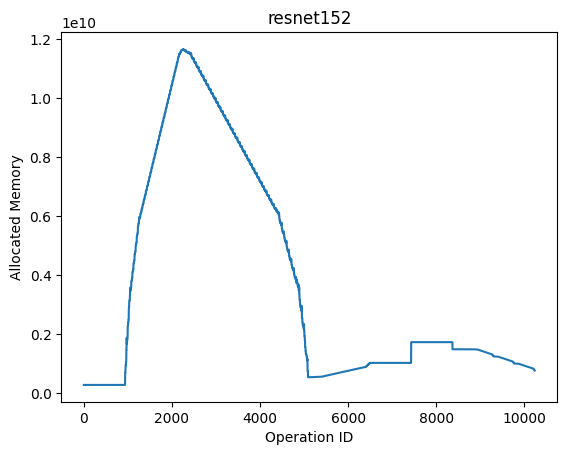

In [31]:
# Plot allocated memory vs. operation id
import matplotlib.pyplot as plt

plt.plot(df["op_id"], df["allocated_mem"])
plt.xlabel("Operation ID")
plt.ylabel("Allocated Memory")
plt.title(file_name[:-4])
plt.show()

## New

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
# hyperparams
batch_size = 256
model_name = "Resnet50"

In [50]:
# Open graph_prof.txt as a pandas dataframe
df_before = pd.read_csv(
    f"results/graph_prof_before_checkpoint_{model_name}_{batch_size}.txt"
)
df_after = pd.read_csv(
    f"results/graph_prof_after_checkpoint_{model_name}_{batch_size}.txt"
)
df

,Node,Node Type,Target,Size (B),Avg runtime (ms),Peak Memory (B),Swap Time (ms)
0,convolution,ACT,torch.ops.aten.convolution.default,51380224,0.777216,212734464,2.094512
1,add_,OTHER,torch.ops.aten.add_.Tensor,512,0.055296,212734464,NaN
2,cudnn_batch_norm,OTHER,torch.ops.aten.cudnn_batch_norm.default,0,0.344064,265164288,NaN
3,getitem,OTHER,operator.getitem,51380224,0.030656,264115712,NaN
4,getitem_1,OTHER,operator.getitem,512,0.016128,264115712,NaN
...,...,...,...,...,...,...,...
858,copy__244,OTHER,torch.ops.aten.copy_.default,2048,0.033792,163197440,NaN
859,copy__245,OTHER,torch.ops.aten.copy_.default,2048,0.029696,163195392,NaN
860,copy__246,OTHER,torch.ops.aten.copy_.default,2048000,0.030720,163193344,NaN
861,copy__247,OTHER,torch.ops.aten.copy_.default,4096,0.028672,160309760,NaN


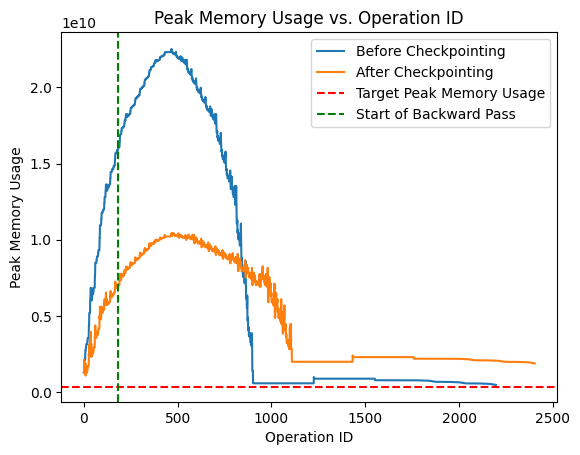

In [ ]:
# PLOT BOTH DFs ON THE SAME PLOT
plt.plot(df_before["Peak Memory (B)"], label="Before Checkpointing")
plt.plot(df_after["Peak Memory (B)"], label="After Checkpointing")

# Plot target peak memory usage
plt.axhline(
    20937965568 // 2, color="red", linestyle="--", label="Target Peak Memory Usage"
)
# Plot start of backward pass
sep_backward_idx = df[df["Node"] == "sep_backward"].index[0]
plt.axvline(
    sep_backward_idx, color="green", linestyle="--", label="Start of Backward Pass"
)

# Plot memory usage by type of node


plt.xlabel("Operation ID")
plt.ylabel("Peak Memory Usage")
plt.title("Peak Memory Usage vs. Operation ID")
plt.legend()

plt.show()
